In [1]:
#=======================================================================
# San-Francisco Crime Classification – two trees, one SVM
# Kaggle competition: https://www.kaggle.com/competitions/sf-crime/code
# DSS8555 Assignment 8
# April 27, 2025
# Min Jeong Lim
#=======================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Configuration
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Load data
train = pd.read_csv('SF Crime/train.csv')  
test = pd.read_csv('SF Crime/test.csv')    
print(f"Data loaded. Train shape: {train.shape}, Test shape: {test.shape}")

Data loaded. Train shape: (878049, 9), Test shape: (884262, 7)


In [2]:
# Cell 2: Feature Engineering

def add_time_feats(df):
    d = pd.to_datetime(df['Dates'])
    df['Year'] = d.dt.year
    df['Month'] = d.dt.month
    df['Day'] = d.dt.day
    df['Hour'] = d.dt.hour
    df['Week'] = d.dt.isocalendar().week.astype(int)
    df['IsWeekend'] = d.dt.dayofweek.isin([5,6]).astype(int)
    df['Night'] = ((df.Hour<6)|(df.Hour>21)).astype(int)
    return df

train = add_time_feats(train)
test = add_time_feats(test)

# Set up features
target = 'Category'
cat_cols = ['DayOfWeek', 'PdDistrict', 'IsWeekend', 'Night']
num_cols = ['X','Y','Hour','Month','Week']
all_cols = cat_cols + num_cols

In [3]:
# Cell 3: Target Processing and Data Split

# Filter rare categories
min_samples = 2
value_counts = train[target].value_counts()
valid_categories = value_counts[value_counts >= min_samples].index
train = train[train[target].isin(valid_categories)]

# Encode target
labels = np.sort(train[target].unique())
label2id = {k:i for i,k in enumerate(labels)}
y = train[target].map(label2id).values

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    train[all_cols], y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)
print(f"Train split: {X_train.shape[0]} samples, Validation: {X_val.shape[0]} samples")

Train split: 702439 samples, Validation: 175610 samples


In [4]:
# Cell 4: Preprocessing Pipeline

pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_cols),
    ('num', StandardScaler(), num_cols)
])


Training Decision Tree...
DecisionTree validation log-loss: 3.5223


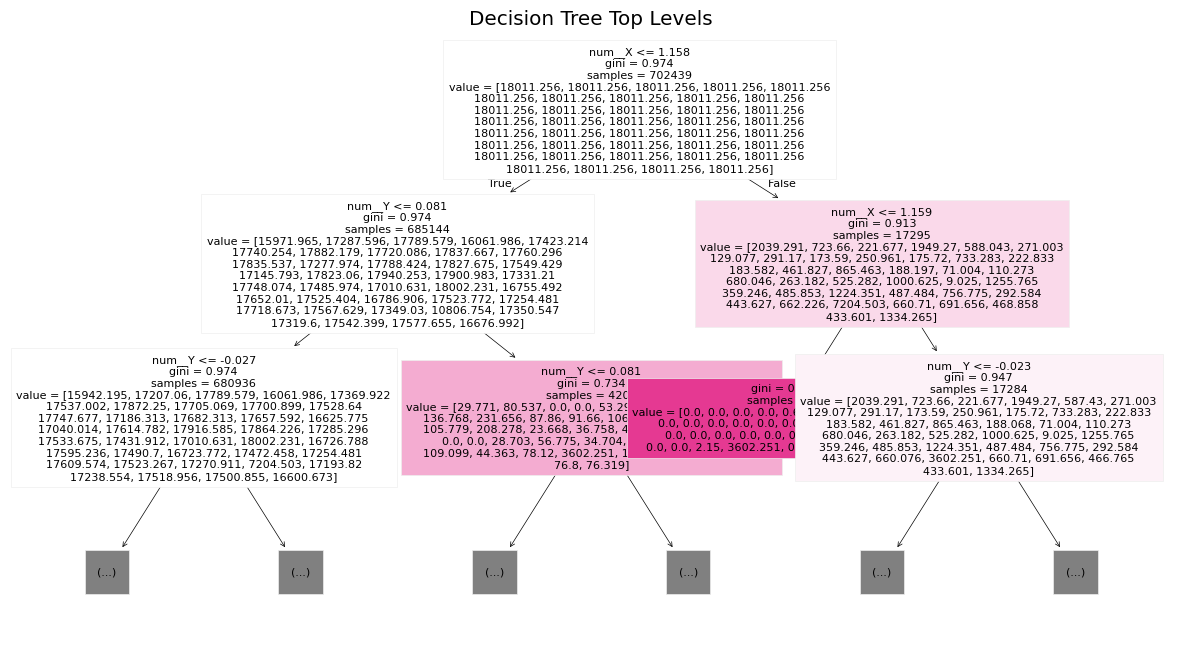

In [5]:
# Cell 5: Model Training - Decision Tree

print("\nTraining Decision Tree...")
tree_clf = Pipeline([
    ('prep', pre),
    ('clf', DecisionTreeClassifier(max_depth=10, min_samples_leaf=10,
                                 class_weight='balanced', random_state=42))
])
tree_clf.fit(X_train, y_train)
tree_proba = tree_clf.predict_proba(X_val)
tree_logloss = log_loss(y_val, tree_proba)
print(f"DecisionTree validation log-loss: {tree_logloss:.4f}")

# Visualization
plt.figure(figsize=(15,8))
plot_tree(tree_clf['clf'], feature_names=tree_clf['prep'].get_feature_names_out(),
         max_depth=2, filled=True, fontsize=8)
plt.title("Decision Tree Top Levels")
plt.show()


Training Random Forest...
RandomForest validation log-loss: 3.2042

Top 15 features by importance:
num__Y                      0.228592
num__X                      0.222629
num__Hour                   0.132526
num__Week                   0.123139
num__Month                  0.090295
cat__DayOfWeek_Friday       0.015711
cat__DayOfWeek_Monday       0.015499
cat__DayOfWeek_Tuesday      0.015016
cat__DayOfWeek_Thursday     0.013539
cat__DayOfWeek_Saturday     0.013253
cat__DayOfWeek_Wednesday    0.013165
cat__PdDistrict_MISSION     0.011109
cat__IsWeekend_0            0.011052
cat__DayOfWeek_Sunday       0.010404
cat__IsWeekend_1            0.010105
dtype: float64


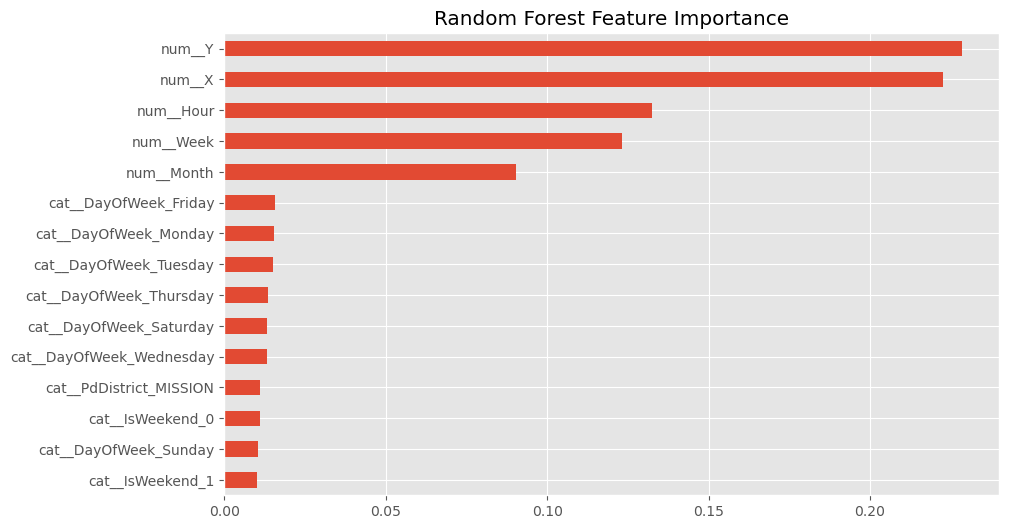

In [6]:
# Cell 6: Model Training - Random Forest

print("\nTraining Random Forest...")
rf_clf = Pipeline([
    ('prep', pre),
    ('clf', RandomForestClassifier(n_estimators=50, max_depth=15,
                                 min_samples_leaf=5, class_weight='balanced_subsample',
                                 n_jobs=-1, random_state=42))
])
rf_clf.fit(X_train, y_train)
rf_proba = rf_clf.predict_proba(X_val)
rf_logloss = log_loss(y_val, rf_proba)
print(f"RandomForest validation log-loss: {rf_logloss:.4f}")

# Feature importance
feat_imp = pd.Series(rf_clf['clf'].feature_importances_,
                    index=rf_clf['prep'].get_feature_names_out()
                   ).sort_values(ascending=False)[:15]
print("\nTop 15 features by importance:")
print(feat_imp)

plt.figure(figsize=(10,6))
feat_imp.sort_values().plot(kind='barh')
plt.title("Random Forest Feature Importance")
plt.show()

In [9]:
# Cell 7: SVM Training with 100 MI-selected features

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection   import StratifiedShuffleSplit
from sklearn.svm               import LinearSVC
from sklearn.calibration       import CalibratedClassifierCV

print("\nTraining SVM with 100 MI-selected features …")

# 1.  Pipeline: preprocess → MI feature selection → calibrated linear SVM
svm_clf = Pipeline([
    ('prep',   pre),                                        # one-hot + scale
    ('select', SelectKBest(mutual_info_classif, k=100)),    # keep top 100
    ('clf',    CalibratedClassifierCV(                      # probability output
                   estimator=LinearSVC(
                       C=0.01, class_weight='balanced',
                       max_iter=1000, dual=False, tol=1e-3,
                       random_state=42),
                   method='sigmoid', cv=2, n_jobs=1))
])

# 2.  Take a **stratified** 50 000-row sample so every class appears ≥2×
sss = StratifiedShuffleSplit(n_splits=1, test_size=50_000, random_state=42)
sub_idx, _ = next(sss.split(X_train, y_train))
X_small    = X_train.iloc[sub_idx]
y_small    = y_train[sub_idx]

# 3.  Fit, predict, and log-loss on validation
svm_clf.fit(X_small, y_small)
svm_proba   = svm_clf.predict_proba(X_val)
svm_logloss = log_loss(y_val, svm_proba)
print(f"SVM validation log-loss: {svm_logloss:.4f}")

# 4.  Show first 20 selected feature names
feat_names = svm_clf.named_steps['prep'].get_feature_names_out()
selected   = svm_clf.named_steps['select'].get_support()
print("Top selected features:", feat_names[selected][:20])



Training SVM with 100 MI-selected features …
SVM validation log-loss: 2.5950
Top selected features: ['cat__DayOfWeek_Friday' 'cat__DayOfWeek_Monday' 'cat__DayOfWeek_Saturday'
 'cat__DayOfWeek_Sunday' 'cat__DayOfWeek_Thursday'
 'cat__DayOfWeek_Tuesday' 'cat__DayOfWeek_Wednesday'
 'cat__PdDistrict_BAYVIEW' 'cat__PdDistrict_CENTRAL'
 'cat__PdDistrict_INGLESIDE' 'cat__PdDistrict_MISSION'
 'cat__PdDistrict_NORTHERN' 'cat__PdDistrict_PARK'
 'cat__PdDistrict_RICHMOND' 'cat__PdDistrict_SOUTHERN'
 'cat__PdDistrict_TARAVAL' 'cat__PdDistrict_TENDERLOIN' 'cat__IsWeekend_0'
 'cat__IsWeekend_1' 'cat__Night_0']


In [10]:
# Cell 8: Model Comparison

results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'SVM'],
    'Log-Loss': [tree_logloss, rf_logloss, svm_logloss]
}).sort_values('Log-Loss')

print("\n\nModel Performance Comparison:")
print(results.to_string(index=False))

best_model_name = results.iloc[0]['Model'].replace(' ', '').lower()
best_model = {'tree': tree_clf, 'rf': rf_clf, 'svm': svm_clf}[best_model_name]
print(f"\nBest model: {best_model_name} (log-loss: {results.iloc[0]['Log-Loss']:.4f})")



Model Performance Comparison:
        Model  Log-Loss
          SVM  2.595016
Random Forest  3.204248
Decision Tree  3.522256

Best model: svm (log-loss: 2.5950)


In [13]:
# Cell 9: Generate All Submissions

print("\nGenerating submissions for all models...")

# Create a dictionary of all models
models = {
    'decision_tree': tree_clf,
    'random_forest': rf_clf,
    'svm': svm_clf
}

# Generate predictions for each model
for model_name, model in models.items():
    try:
        proba = model.predict_proba(test[all_cols])  # Use predict_proba for all models

        # Create submission DataFrame
        submission = pd.DataFrame(proba, columns=labels)
        submission.insert(0, 'Id', test['Id'])

        # Save to CSV
        filename = f'submission_{model_name}.csv'
        submission.to_csv(filename, index=False)

        print(f"Saved {filename}")

    except Exception as e:
        print(f"Error generating {model_name} submission: {str(e)}")

print("\nAll submission files created:")
print("- submission_decision_tree.csv")
print("- submission_random_forest.csv") 
print("- submission_svm.csv")


Generating submissions for all models...
Saved submission_decision_tree.csv
Saved submission_random_forest.csv
Saved submission_svm.csv

All submission files created:
- submission_decision_tree.csv
- submission_random_forest.csv
- submission_svm.csv
